# Investigating Trigger Efficiency at Maximum Trigger Rate with Uniform Illumination

This is the second notebook to explore measuring the trigger efficiency using the sstcam-simulation package. The approach in the first notebook was to select a safe threshold based on the intersection between the NSB bias curve and the periodic laser flash rate. Instead, this notebook operates with the principle of choosing a threshold which results in an "maximum allowed camera trigger rate", on the order of 200-600 Hz. Majority of these triggers will be from NSB.

Our aim in these investigations is to change various parameters of the camera design (e.g. pulse shape) to investigate the corresponding uniform illumination trigger efficiency, and to make recommendations on the final camera design. In summary, we ask:
1. What is the acceptable accidental camera trigger rate on the NSB?
2. What is the superpixel trigger rate that corresponds to that camera trigger rate?
3. What is the camera configuration we want to test?
4. What is the superpixel threshold we need to maintain this trigger rate for this camera configuration?
5. What is the resulting trigger efficiency for the camera configuration at this threshold?

In [1]:
from sstcam_simulation import Camera, SSTCameraMapping, PhotoelectronSource, EventAcquisition
from sstcam_simulation.camera.spe import SiPMGentileSPE, PerfectPhotosensor
from sstcam_simulation.camera.pulse import GaussianPulse
from sstcam_simulation.event.trigger import sum_superpixels
import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
%matplotlib inline

## Step 1: Accidental Camera Trigger Rate

One approach to define the acceptable camera trigger rate is by considering the intersection of the NSB-dominant section of the trigger bias curve, and the CR-dominant section. The "safe threshold" definition is often obtained by considering twice the operating NSB (see the document by Tom Armstrong in this github directory). This definition gaurantess an accidental NSB trigger rate which is less than the CR trigger rate.

Alternatively, one can select a trigger rate which one expects the camera to be able to handle. NSB may be the majority cause of triggers at this rate, but the array trigger can be relied on to extract to flag the Cherenkov shower events that we wish to keep. The primary caveat in this approach is the dead time - allow too high of an NSB trigger rate, and you will miss the cosmic ray triggers which may have resulted in an array trigger.

For this investigation I will assume a camera trigger rate of 200 Hz results in an acceptable accidental trigger rate. This value comes from the values assumed in the 2012 trigger efficiency investigation document by Jim and Stefan. Once sstcam-simulation can simulate a CR population, the value can be confirmed as acceptable.

In [2]:
# Define an acceptable camera trigger rate
requested_camera_trigger_rate = 200  # Hz

## Step 2: Corresponding Superpixel Trigger Rate

The relationship between the camera trigger rate and the pixel trigger rate for uncorrelated triggers can be found from the [statistical evaluation of coincident triggers](http://courses.washington.edu/phys433/muon_counting/statistics_tutorial.pdf)

And can be summarised in the equation:

$$f = \sum_{n=i}^{N_{comb}}( t_{coinc}^{N - 1} \prod_{n=0}^{N} f_{in})$$

$f$ = Camera trigger rate

$N_{comb}$ = Number of possible trigger group combinations

$N$ = Number of trigger groups involved in creating the trigger (multiplicity)

$f_{in}$ = Trigger rate of the trigger group

$t_{coinc}$ = Coincidence time required between the trigger groups

For the NN superpixel scheme in the SST camera, where the multiplicity is 2 and the total number of combinations is 2 x 1910, this can be simplified to:

$$f = 2 \times 1910 \times f_{sp}^2 \times t_{coinc}$$

This relationship is demonstrated to hold for sstcam-simulation below:

In [3]:
camera = Camera(
    mapping=SSTCameraMapping(n_pixels=2048), 
    trigger_threshold=2,
    digital_trigger_length=10,
)
nsb_array = np.linspace(1, 10, 5)  # MHz
source = PhotoelectronSource(camera=camera)
acquisition = EventAcquisition(camera=camera)
n_repeats = 5  # Repeats for statistics
n_sp_triggers = np.zeros((n_repeats, nsb_array.size))
n_camera_triggers = np.zeros((n_repeats, nsb_array.size))
for i, nsb in tqdm(enumerate(nsb_array), desc="Measuring uncorrelated triggers", total=nsb_array.size):
    for iev in range(n_repeats):
        photoelectrons = source.get_nsb(nsb)
        readout = acquisition.get_continuous_readout(photoelectrons)
        digital_trigger = acquisition.trigger.get_superpixel_digital_trigger_line(readout)
        n_sp_triggers[iev, i] = acquisition.trigger.get_n_superpixel_triggers(digital_trigger).mean()
        n_camera_triggers[iev, i] = np.unique(acquisition.get_trigger(readout)).size
        
duration = camera.continuous_readout_duration * 1e-9  # seconds
sp_rate = n_sp_triggers.mean(0) / duration
sp_rate_err = n_sp_triggers.std(0) / duration
camera_rate = n_camera_triggers.mean(0) / duration
camera_rate_err = n_camera_triggers.std(0) / duration

In [4]:
def calculate_expected_superpixel_rate(camera_rate, camera):
    n_combinations = 2 * 1910
    coincidence_length = camera.digital_trigger_length * 1e-9
    return np.sqrt(camera_rate / (n_combinations * coincidence_length))

Presumed Coincidence Length = 10.0 ns
Effective Coincidence Length = 7.57 ns


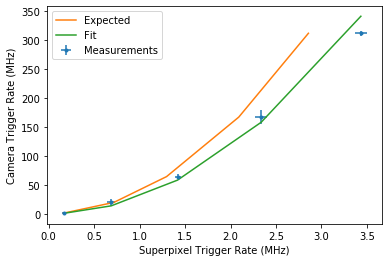

In [8]:
sp_rate_mhz = sp_rate * 1e-6
sp_rate_err_mhz = sp_rate_err * 1e-6
camera_rate_mhz = camera_rate * 1e-6
camera_rate_err_mhz = camera_rate_err * 1e-6

plt.errorbar(
    sp_rate_mhz, camera_rate_mhz, 
    xerr=sp_rate_err_mhz, yerr=camera_rate_err_mhz, 
    fmt='.', label="Measurements"
)

expected_sp_rate = calculate_expected_superpixel_rate(camera_rate, camera)
expected_sp_rate_mhz = expected_sp_rate * 1e-6
plt.plot(expected_sp_rate_mhz, camera_rate_mhz, label="Expected")

c = polyfit(2 * 1910 * sp_rate**2, camera_rate, [1], w=camera_rate_err)
fit_y = polyval(2 * 1910 * sp_rate**2, c) * 1e-6
plt.plot(sp_rate_mhz, fit_y, label="Fit")

coincidence_length = camera.digital_trigger_length * 1e-9
effective_coincidence_length = c[1]

plt.xlabel("Superpixel Trigger Rate (MHz)")
plt.ylabel("Camera Trigger Rate (MHz)")
plt.legend()

print(f"Presumed Coincidence Length = {coincidence_length * 1e9:.3} ns")
print(f"Effective Coincidence Length = {effective_coincidence_length * 1e9:.3} ns")

The relationship does not fully follow the expected equation due to the triggers that are not counted as they occur in a period where another trigger has already occured. However, the discrepency is small enough for our purposes, so the equation will still be used.

In [9]:
requested_sp_trigger_rate = calculate_expected_superpixel_rate(
    requested_camera_trigger_rate, camera
)
print(f"Requested SP trigger rate = {requested_sp_trigger_rate:.6} Hz")

Requested SP trigger rate = 2288.14 Hz


## Step 3: Camera configuration

In [46]:
camera = Camera(
    mapping=SSTCameraMapping(n_pixels=4),  # One Superpixel 
    digital_trigger_length=8,  # ns
    continuous_readout_duration=128,  # ns
)

## Step 4: Trigger Threshold

The bias curve provides a conversion between rate and threshold. There are multiple ways in which one could extract the threshold for a given rate. For this investigation I use a simple fit to the NSB bias curve with a straight line in log space. 

In [47]:
nsb_rate = 40  # MHz

In [68]:
def perform_nsb_bias_scan(camera, nsb, thresholds):
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)
    n_repeats = 1000  # Repeats for statistics
    n_triggers = np.zeros((n_repeats, thresholds.size))
    for iev in trange(n_repeats, desc="Measuring bias curve"):
        photoelectrons = source.get_nsb(nsb)
        readout = acquisition.get_continuous_readout(photoelectrons)
        for i, thresh in enumerate(thresholds):
            camera.update_trigger_threshold(thresh)
            digital_trigger = acquisition.trigger.get_superpixel_digital_trigger_line(readout)
            n_triggers[iev, i] = acquisition.trigger.get_n_superpixel_triggers(digital_trigger)
    rate = n_triggers / (camera.continuous_readout_duration * 1e-9)
    return rate.mean(0), rate.std(0)

In [55]:
def get_threshold_for_rate(thresholds, scan, requested_rate):
    gt0 = scan > 0
    gradient, y_intercept = np.polyfit(thresholds[gt0], np.log10(scan[gt0]), 1)
    required_threshold = (np.log10(requested_rate) - y_intercept) / gradient    
    return required_threshold, gradient, y_intercept

In [56]:
thresholds = np.linspace(4, 15, 10)  # Units: photoelectron

In [57]:
# Perform bias scans (first one is for plotting purposes only)
scan, scan_err = perform_nsb_bias_scan(camera, nsb_rate, thresholds)
#scan_x2, scan_err_x2 = perform_nsb_bias_scan(camera, nsb_rate*2, thresholds)

In [58]:
threshold, gradient, y_intercept = get_threshold_for_rate(thresholds, scan, requested_sp_trigger_rate)

Text(0, 0.5, 'Trigger Rate (Hz)')

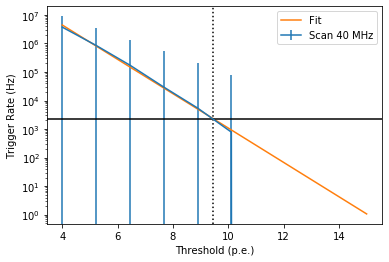

In [59]:
# Demonstrate the fit
plt.errorbar(thresholds, scan, yerr=scan_err, label=f"Scan {nsb_rate} MHz")
#plt.errorbar(thresholds, scan_x2, yerr=scan_err_x2, label=f"Scan {nsb_rate*2} MHz")
plt.plot(thresholds, 10**np.polyval([gradient, y_intercept], thresholds), label="Fit")
plt.axhline(requested_sp_trigger_rate, color='black', ls='-')
plt.axvline(threshold, color='black', ls=':')

plt.yscale('log')
plt.legend()
plt.xlabel("Threshold (p.e.)")
plt.ylabel("Trigger Rate (Hz)")

In [64]:
print(f"Required threshold = {threshold:.3} p.e.")
camera.update_trigger_threshold(threshold)

Required threshold = 9.46 p.e.


## Step 5: Trigger Efficiency



In [61]:
def extract_trigger_ratio(camera, nsb_rate, illumination_level):
    n_simulated = 2000
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)
    
    signal_time = camera.continuous_readout_duration / 2
    n_triggers = 0
    for _ in range(n_simulated):
        photoelectrons = source.get_nsb(nsb_rate)
        photoelectrons += source.get_uniform_illumination(signal_time, illumination_level, laser_pulse_width=5)        
        readout = acquisition.get_continuous_readout(photoelectrons)
        digital_trigger = acquisition.trigger.get_superpixel_digital_trigger_line(readout)
        n_triggers += acquisition.trigger.get_n_superpixel_triggers(digital_trigger)
    return n_triggers / n_simulated

In [62]:
illumination_levels = np.linspace(0, 6, 20)
ratio = np.zeros(illumination_levels.size)

for i, level in enumerate(tqdm(illumination_levels, desc="Iterating through illumination levels")):
    ratio[i] = extract_trigger_ratio(camera, nsb_rate, level)

Amplitude @ 50% Trigger Efficiency = 3.680 p.e.


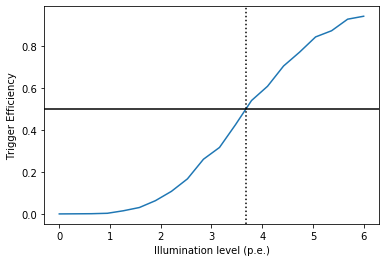

In [65]:
amplitude_50 = np.interp(0.5, ratio, illumination_levels)

plt.plot(illumination_levels, ratio)
plt.axhline(0.5, color='black', ls='-')
plt.axvline(amplitude_50, color='black', ls=':')
plt.xlabel("Illumination level (p.e.)")
plt.ylabel("Trigger Efficiency")

print(f"Amplitude @ 50% Trigger Efficiency = {amplitude_50:.3f} p.e.")

# Full Chain for Multiple Configurations

Now that each step in the chain has been verbosely demonstrated, we can perform the entire chain for multiple camera configurations in an attempt to find an optimal camera design.

In [69]:
def obtain_amplitude_at_50_percent(camera):
    # Define an acceptable camera trigger rate
    camera_trigger_rate = 200  # Hz
    sp_trigger_rate = calculate_expected_superpixel_rate(camera_trigger_rate, camera)
    
    # Bias scan to find threshold
    nsb_rate = 40  # MHz
    thresholds = np.linspace(4, 15, 10)  # Units: photoelectron
    scan, scan_err = perform_nsb_bias_scan(camera, nsb_rate, thresholds)
    threshold, _, _ = get_threshold_for_rate(thresholds, scan, sp_trigger_rate)
    camera.update_trigger_threshold(threshold)
    
    # Illumination scan to obtain trigger efficiency
    illumination_levels = np.linspace(0, 15, 10)
    ratio = np.zeros(illumination_levels.size)
    for i, level in enumerate(tqdm(illumination_levels, desc="Iterating through illumination levels")):
        ratio[i] = extract_trigger_ratio(camera, nsb_rate, level)
    amplitude_50 = np.interp(0.5, ratio, illumination_levels)
    
    return amplitude_50

In [70]:
sigma_array = np.linspace(1, 15, 10)
amplitude_array = np.zeros(sigma_array.size)
desc = "Extracting Trigger Efficiency for Camera"
for i, sigma in tqdm(enumerate(sigma_array), total=sigma_array.size, desc=desc):
    camera = Camera(
        mapping=SSTCameraMapping(n_pixels=4),  # One Superpixel 
        digital_trigger_length=8,  # ns
        reference_pulse=GaussianPulse(sigma=sigma, duration=50, mean=25),
    )
    amplitude_array[i] = obtain_amplitude_at_50_percent(camera)
    #plt.plot(camera.reference_pulse.time, camera.reference_pulse.pulse)

Text(0, 0.5, 'Amplitude @ 50% Trigger Efficiency (p.e.)')

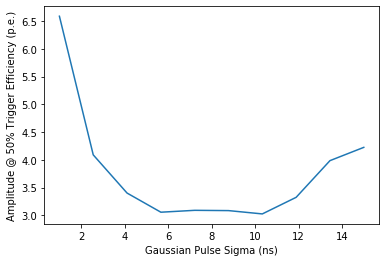

In [71]:
plt.plot(sigma_array, amplitude_array)
plt.xlabel("Gaussian Pulse Sigma (ns)")
plt.ylabel("Amplitude @ 50% Trigger Efficiency (p.e.)")

Therefore, in designing a camera to be optimised for uniform laser light, with a illumination pulse of 5 ns, and in the presence of 40 MHz NS